## **Notebook Summary**

### **Purpose**
This notebook evaluates and visualizes the performance of a clinical trial-patient matching system ("trial_matches.json"), comparing system-assigned trial suitability verdicts against curated gold-standard labels.

---

### **Key Steps and Logic**

#### **1. Data Loading**
- Loads:
  - **Gold/reference** patient-trial pairs and scores from `test.tsv`.
  - **Patient queries** and **trial corpus** from `queries.jsonl` and `corpus.jsonl`.
  - **Trial matches** (detailed matching outputs) from `matched/trial_matches.json` (contains verdicts, reasoning about inclusion/exclusion).

#### **2. Flatten & Normalize Trial Matches**
- Iterates through `trial_matches.json` to **flatten nested structures** into a DataFrame:
  - Columns include: `query-id`, `corpus-id`, model trial verdict (`match_verdict`), reasoning, inclusion/exclusion flags, and detailed eligibility explanations.

#### **3. Merge Gold with System Predictions**
- Merges gold-standard pairs (`df_tsv`) with matched verdicts (`df_trial_matches`) by query and trial IDs.
- Ensures **all gold pairs are present**, filling unmatched ones with NaN for later filtering/checks.

#### **4. Label Harmonization**
- Maps system verdicts (“STRONG MATCH”, “POSSIBLE MATCH”, “WEAK MATCH”, “UNSUITABLE”) into numeric label space {0, 1, 2} for comparison:
  - 2: Highly likely ("STRONG MATCH" or "POSSIBLE MATCH")
  - 1: Would consider ("WEAK MATCH")
  - 0: Would not refer ("UNSUITABLE")
- Aligns ground-truth labels from gold file into the same space.

#### **5. Evaluation**
- **Omissions:** Reports count/samples of pairs where there is no system verdict (excluded from scoring).
- **Metrics:**
  - Computes **confusion matrix** (tabular and heatmap) to visualize agreement.
  - Calculates **macro-averaged F1 score** and displays a full classification report (precision/recall per label).
- **Visualization:** Plots the confusion matrix with Seaborn for a clear model performance summary.

#### **6. Inspection & Quality Control**
- Provides options to display merged/evaluated DataFrame (with explanations/reasoning), as well as any omitted/missing rows.

#### **7. Display/Output**
- Configures pandas for wide displays, allowing direct inspection of large slices of merged data and reasoning fields.

---

### **Outputs**
- **Metrics for Model QA:** Confusion matrix, macro F1, precision/recall for each decision level.
- **Visualization:** Color-coded confusion matrix heatmap for rapid error pattern assessment.
- **Inspection:** Full merged DataFrame can be displayed, supporting qualitative analysis via system reasoning and verdicts.

---

### **Intended Use**
- **Model validation and debugging:** Evaluate system-patient-to-trial assignment quality.
- **Insight into errors:** Directly reveals misclassifications and their reasoning by exploring DataFrame rows.
- **Transparent reporting:** Well-suited for sharing system strengths and weaknesses with stakeholders or during clinical IR system development.

---

### **Technical/Architectural Notes**
- **Robust merging:** Ensures all reference pairs are considered, not just those found by the matcher.
- **Extendable:** Can be easily fit for other datasets or more granular scoring/justification analysis.
- **User-friendly:** Designed for rapid exploratory analysis, including straightforward displays for both summary and raw data.

In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
# Set pandas display options 
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 400)

In [3]:
import os
import pandas as pd
import json

# Set up paths
DATA_DIR = "../data/sigir2016/processed_cut"
MATCHED_DIR = "../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load main input data
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

In [4]:
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

 df_tsv 3870 df_queries 59 df_corpus 3626


In [5]:
# Glimpse at dataframes:
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())
# display(trial_matches_long.head())

# ---- Now you can proceed with analysis & evaluation below!

,query-id,corpus-id,score
0,sigir-20141,NCT00000408,0
1,sigir-20141,NCT00000492,1
2,sigir-20141,NCT00000501,0
3,sigir-20141,NCT00001853,0
4,sigir-20141,NCT00004727,0


,_id,text
0,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is not increased on inspiration. The latest episode of pain ended half an hour prior to her arrival. Sh..."
1,sigir-20142,"An 8-year-old male presents in March to the ER with fever up to 39 C, dyspnea and cough for 2 days. He has just returned from a 5 day vacation in Colorado. Parents report that prior to the onset of fever and cough, he had loose stools. He denies upper respiratory tract symptoms. On examination he is in respiratory distress and has bronchial respiratory sounds on the left. A chest x-ray shows b..."
2,sigir-20143,"A 58-year-old nonsmoker white female with mild exertional dyspnea and occasional cough is found to have a left lung mass on chest x-ray. She is otherwise asymptomatic. A neurologic examination is unremarkable, but a CT scan of the head shows a solitary mass in the right frontal lobe."
3,sigir-20144,"A 2-year-old boy is brought to the emergency department by his parents for 5 days of high fever and irritability. The physical exam reveals conjunctivitis, strawberry tongue, inflammation of the hands and feet, desquamation of the skin of the fingers and toes, and cervical lymphadenopathy with the smallest node at 1.5 cm. The abdominal exam demonstrates tenderness and enlarged liver. Laborator..."
4,sigir-20145,A 56-year-old female on 20th day post-left mastectomy presents to the emergency department complaining of shortness of breath and malaise. The patient says that she has remained in bed for the last two weeks. The physical examination reveals tenderness on the left upper thoracic wall and right calf. The surgical incision shows no bleeding or signs of infection. Pulmonary auscultation is signif...


,_id,title,metadata
0,NCT00000369,Maintenance Therapies in Bipolar Disorders,"{'phase': 'Phase 3', 'drugs': '['Individual psychotherapy', 'Lithium carbonate']', 'drugs_list': ['Individual psychotherapy', 'Lithium carbonate'], 'diseases_list': ['Bipolar Disorder'], 'enrollment': '0', 'inclusion_criteria': 'Patients must have: Acute bipolar I illness and be experiencing a manic or depressed episode at the time of study entry. Required: Current treatment with lithium carbo..."
1,NCT00000402,Calcium and Bone Mass in Young Females,"{'phase': 'Phase 2', 'drugs': '['Calcium']', 'drugs_list': ['Calcium'], 'diseases_list': ['Osteoporosis'], 'enrollment': '354', 'inclusion_criteria': '- Pubertal stage II - Calcium intake below a threshold level - Caucasian - Normal health', 'exclusion_criteria': '- Medications affecting calcium and bone metabolism - Chronic diseases - Metabolic bone disease - Abnormality in calcium metabolism..."
2,NCT00000408,Low Back Pain Patient Education Evaluation,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ['Patient education evaluation'], 'diseases_list': ['Low Back Pain'], 'enrollment': '580', 'inclusion_criteria': '- Must live in the United States - Must understand and write English - Must have access to a computer with e-mail and expect to have this access for at least 3 years - Must be 18 years old - Must have seen ..."
3,NCT00000430,Low-Dose Hormone Replacement Therapy and Alendronate for Osteoporosis,"{'phase': 'Phase 3', 'drugs': '['Alendronate', 'Estrogen/progestin therapy']', 'drugs_list': ['Alendronate', 'Estrogen/progestin therapy'], 'diseases_list': ['Osteopenia', 'Osteoporosis'], 'enrollment': '240', 'inclusion_criteria': '- Women at least 60 years of age. - Good general health. - Willingness to participate in this 3.5 year study. - Ability to give informed consent. - Ability to live..."
4,NCT00000432,Lyme Disease Prevention Program,"{'phase': 'Phase 3', 'drugs': '['Education about disease prevention']', 'drugs_list': ['Education about disease prevention'], 'diseases_list': ['Lyme Disease', 'Tick-Borne Diseases'], 'enrollment': '20000', 'inclusion_criteria': '- Ferry passengers traveling to Nantucket Island', 'exclusion_criteria': '- Foreign (non-U.S.) residence', 'brief_summary': 'This is a large study of an educational p..."


In [6]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the JSON as a list of dicts
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flattening loop
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Create DataFrame
df_trial_matches = pd.DataFrame(records)

# Preview
# pd.set_option('display.max_colwidth', 200)
# display(df_trial_matches.head())

In [7]:
df_trial_matches['score'] = df_trial_matches['score'].fillna(0)
df_trial_matches['match_verdict'] = df_trial_matches['match_verdict'].fillna("WOULD NOT REFER")

In [8]:
len(df_trial_matches)

7552

In [9]:
# df_tsv: gold/reference pairs
# df_trial_matches: detailed match+reasoning info from trial_matches.json

# Merge, keeping all gold standard pairs and including trial_matches info when available:
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

In [10]:
# 1. Merge queries info (like 'text') into merged_df
merged_df = merged_df.merge(
    df_queries.rename(columns={'_id': 'query-id'}),
    on='query-id',
    how='left'
)

# 2. Merge corpus info (like 'title', 'metadata') into merged_df
merged_df = merged_df.merge(
    df_corpus.rename(columns={'_id': 'corpus-id'}),
    on='corpus-id',
    how='left'
)
# Drop the 'title' column
merged_df = merged_df.drop(columns=['title'])

Rows with missing match_verdict (excluded from evaluation): 1746

Confusion matrix (table):



,0) WOULD NOT REFER,1) WOULD CONSIDER REFERRAL,2) HIGHLY LIKELY TO REFER
0) WOULD NOT REFER,1049,158,18
1) WOULD CONSIDER REFERRAL,280,230,37
2) HIGHLY LIKELY TO REFER,117,166,69



Macro F1 score: 0.4977

Detailed classification report:

                            precision    recall  f1-score   support

        0) WOULD NOT REFER       0.73      0.86      0.79      1225
1) WOULD CONSIDER REFERRAL       0.42      0.42      0.42       547
 2) HIGHLY LIKELY TO REFER       0.56      0.20      0.29       352

                  accuracy                           0.63      2124
                 macro avg       0.57      0.49      0.50      2124
              weighted avg       0.62      0.63      0.61      2124



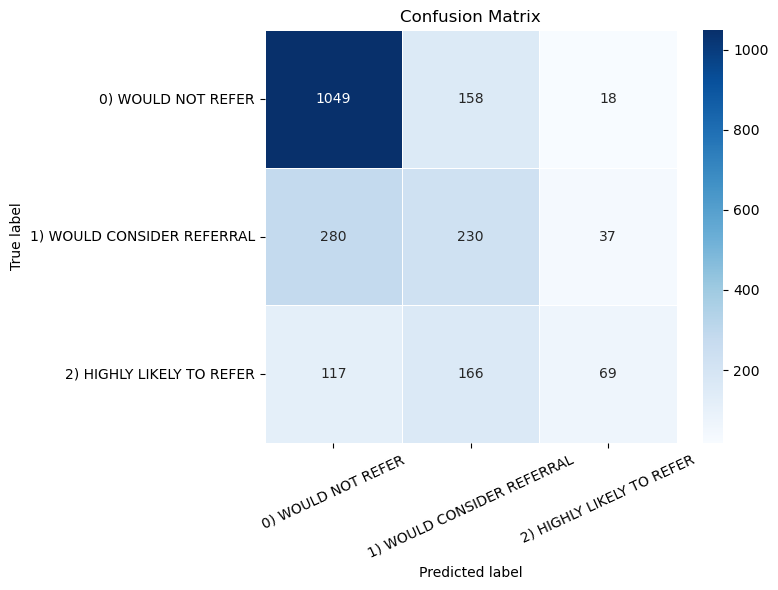

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd

verdict_map = {
    "HIGHLY LIKELY TO REFER": 2,
    "WOULD CONSIDER REFERRAL": 1,
    "WOULD NOT REFER": 0,
    "None": 0,
}

merged_df['predicted_label'] = merged_df['match_verdict'].map(verdict_map)#.fillna(0).astype(int)
merged_df['true_label'] = merged_df['score_x']

labels = [0, 1, 2]
label_names = [
    "0) WOULD NOT REFER",
    "1) WOULD CONSIDER REFERRAL",
    "2) HIGHLY LIKELY TO REFER"
]

n_missing = merged_df['match_verdict'].isna().sum()
print(f"Rows with missing match_verdict (excluded from evaluation): {n_missing}")

eval_df = merged_df[~merged_df['predicted_label'].isna() & ~merged_df['true_label'].isna()]
y_true = eval_df['true_label'].astype(int)
y_pred = eval_df['predicted_label'].astype(int)

cm = confusion_matrix(y_true, y_pred, labels=labels)
f1 = f1_score(y_true, y_pred, labels=labels, average='macro')

print("\nConfusion matrix (table):\n")
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
display(cm_df)

print("\nMacro F1 score: {:.4f}".format(f1))
print("\nDetailed classification report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=label_names))

# Blue Confusion Matrix Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# # Show omitted rows if any
# if n_missing > 0:
#     print("\nSample of omitted rows (no match_verdict):")
#     display(merged_df[merged_df['match_verdict'].isna()].head())

In [12]:
# Set pandas display options 
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [13]:
# Cell 1: True label 2, prediction available
df_true2_pred = merged_df[(merged_df["score_x"] == 2) & (merged_df["predicted_label"] == 0)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

query-id    corpus-id  score_x  \
18     sigir-20141  NCT00175279        2   
81     sigir-20141  NCT01253486        2   
106    sigir-20141  NCT01724567        2   
202   sigir-201410  NCT02634138        2   
253   sigir-201412  NCT00497575        2   
...            ...          ...      ...   
3572   sigir-20155  NCT01886846        2   
3613   sigir-20156  NCT00588432        2   
3630   sigir-20156  NCT01247077        2   
3668   sigir-20156  NCT02375451        2   
3690   sigir-20157  NCT00360451        2   

                                                                                                                                                                             trial_title  \
18    A Cluster Randomized Trial to Assess the Impact of Opinion Leader Endorsed Evidence Summaries on Improving Quality of Prescribing for Patients With Chronic Cardiovascular Disease   
81                                                                                                                                                  Expressive Writing for Heart Healing   
106                                                                       Copenhagen Study of Obese Patients With Ischemic Heart Disease Undergoing Low Energy Diet or Interval Training   
202                                                                                                        Neuromuscular Electrical Stimulation in Patients With Critical Limb Ischaemia   
253                                                                                                                  Diagnosis and Follow-up of Patients With Subclinical Hypothyroidism   
...                                                                                                                                                                                  ...   
3572                                                                                       Plasma Adiponectin Levels and Relations With Cytokines in Children With Acute Rheumatic Fever   
3613                                                                                                     Characterization of Skeletal Muscle Using Magnetic Resonance Elastography (MRE)   
3630                                                                              Neuropsychologic and Immunological Evaluation in Treatment of Thyroid Diseases. Is Selenium Efficient?   
3668                                                                                                                        Effect of Childhood Radioiodine Therapy on Salivary Function   
3690                                                                            Effectiveness of School-Based Cognitive Behavioral Therapy in Preventing Depression in Young Adolescents   

     score_y    match_verdict  \
18         0  WOULD NOT REFER   
81         0  WOULD NOT REFER   
106        4  WOULD NOT REFER   
202        0  WOULD NOT REFER   
253        2  WOULD NOT REFER   
...      ...              ...   
3572       2  WOULD NOT REFER   
3613       0  WOULD NOT REFER   
3630       0  WOULD NOT REFER   
3668       2  WOULD NOT REFER   
3690       0  WOULD NOT REFER   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          match_reasoning  \
18                                                                                                                                                                                                            

Rows: 117


In [14]:
# Cell 1: True label 2, prediction available
df_true2_pred = merged_df[(merged_df["score_x"] == 2) & (merged_df["predicted_label"] == 2)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

query-id    corpus-id  score_x  \
6      sigir-20141  NCT00005485        2   
172   sigir-201410  NCT01599195        2   
505   sigir-201417  NCT00006319        2   
861   sigir-201421  NCT00006055        2   
862   sigir-201421  NCT00008749        2   
...            ...          ...      ...   
3071  sigir-201524  NCT01075204        2   
3109  sigir-201524  NCT02489578        2   
3271  sigir-201529  NCT00000520        2   
3666   sigir-20156  NCT02210741        2   
3688   sigir-20157  NCT00290914        2   

                                                                                                                                                       trial_title  \
6                                                                     Environmental and Genetic Factors That Influence Cardiovascular Disease in African Americans   
172                                                                             Use of Amplified Sound Signal to Identify Presence of Carotid and Femoral Stenosis   
505                                                                                            Molecular and Clinical Studies of Primary Immunodeficiency Diseases   
861                                                    Autologous Peripheral Blood Stem Cell Transplantation in Patients With Life Threatening Autoimmune Diseases   
862                                                                                 Role of Altered CD40-Ligand Gene Transcription in Systemic Lupus Erythematosus   
...                                                                                                                                                            ...   
3071  Clarithromycin Modified Release Observational Study for Evaluation of Treatment, Tolerability & Recovery Time in Saudi & Egyptian Clinical Settings (CLOSER)   
3109                                                         A Retrospective Study on Hospitalized Patients With Community-acquired Pneumonia in China (CAP-China)   
3271                                                                                                         Prevention of Coronary Aneurysms in Kawasaki Syndrome   
3666                                                                     Next-generation Sequencing (NGS) of Peripheral Blood Immune Repertoire in Graves' Disease   
3688                   Safety and Efficacy Study of Vilazodone and Discovering Genetic Markers Associated With Response in Patients With Major Depressive Disorder   

     score_y           match_verdict  \
6          9  HIGHLY LIKELY TO REFER   
172        8  HIGHLY LIKELY TO REFER   
505        8  HIGHLY LIKELY TO REFER   
861        8  HIGHLY LIKELY TO REFER   
862        8  HIGHLY LIKELY TO REFER   
...      ...                     ...   
3071       9  HIGHLY LIKELY TO REFER   
3109       8  HIGHLY LIKELY TO REFER   
3271       9  HIGHLY LIKELY TO REFER   
3666       8  HIGHLY LIKELY TO REFER   
3688       8  HIGHLY LIKELY TO REFER   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       match_reasoning  \
6                                                                                                                                                                                                                                                                                                                                    

Rows: 69


In [15]:
# Cell 2: True label 1, prediction available
df_true1_pred = merged_df[(merged_df["score_x"] == 1) & (merged_df["predicted_label"] == 1)]
display(df_true1_pred)
print(f"Rows: {len(df_true1_pred)}")

query-id    corpus-id  score_x  \
22    sigir-20141  NCT00225355        1   
63    sigir-20141  NCT00979199        1   
71    sigir-20141  NCT01162902        1   
79    sigir-20141  NCT01231165        1   
90    sigir-20141  NCT01407146        1   
...           ...          ...      ...   
3786  sigir-20158  NCT00494468        1   
3798  sigir-20158  NCT01335594        1   
3800  sigir-20158  NCT01554527        1   
3807  sigir-20158  NCT02053012        1   
3816  sigir-20158  NCT02562040        1   

                                                                                                                                       trial_title  \
22                                                                                           Rosiglitazone Versus Placebo in Chronic Stable Angina   
63                                                                              Evaluation of Integrated Cardiac Imaging in Ischemic Heart Disease   
71    Comparison of Vascular Remodeling Between Different Antianginal Medication Evaluated by Noninvasive ECG-gated Fundus Photographic Evaluation   
79                                                                                              Treatment of Coronary Heart Disease With Amiloride   
90                                                                    Acute Coronary Syndrome and Care-Seeking Delay: A Web Based Behavioral Study   
...                                                                                                                                            ...   
3786                                   Single Dose Pharmacokinetic and Pharmacodynamic Evaluation of Three Different Doses of Zolpidem in Children   
3798                                                                             Evaluation of Swallowing in Patients With Obstructive Sleep Apnea   
3800                                                               Continuous Positive Airway Pressure (CPAP) After Adenotonsillectomy in Children   
3807                                                                                          Investigating Reaction Time Among Children Who Snore   
3816                                                                                                      Pediatric Adenotonsillectomy for Snoring   

     score_y            match_verdict  \
22         6  WOULD CONSIDER REFERRAL   
63         6  WOULD CONSIDER REFERRAL   
71         6  WOULD CONSIDER REFERRAL   
79         6  WOULD CONSIDER REFERRAL   
90         6  WOULD CONSIDER REFERRAL   
...      ...                      ...   
3786       6  WOULD CONSIDER REFERRAL   
3798       6  WOULD CONSIDER REFERRAL   
3800       6  WOULD CONSIDER REFERRAL   
3807       6  WOULD CONSIDER REFERRAL   
3816       6  WOULD CONSIDER REFERRAL   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             match_reasoning  \
22                                                                                                                                                               The patient presents with episodic chest pain suggestive of angina, a history of hypertension and obesity, and no known diabetes or family history of heart disease. The trial targets patients with chronic stable angina, which might align with the patient's symptoms, but the diagnosis of chronic stable angina is not explicitly confirmed. The patient's obesity could imply a BMI greater than 25, m

Rows: 230


In [16]:
# Cell 3: True label 0, prediction available
df_true0_pred = merged_df[(merged_df["score_x"] == 0) & (merged_df["predicted_label"] == 0)]
display(df_true0_pred)
print(f"Rows: {len(df_true0_pred)}")

query-id    corpus-id  score_x  \
3     sigir-20141  NCT00001853        0   
17    sigir-20141  NCT00166231        0   
21    sigir-20141  NCT00202566        0   
27    sigir-20141  NCT00356707        0   
34    sigir-20141  NCT00462241        0   
...           ...          ...      ...   
3840  sigir-20159  NCT00992693        0   
3845  sigir-20159  NCT01302418        0   
3852  sigir-20159  NCT01618175        0   
3859  sigir-20159  NCT01891084        0   
3864  sigir-20159  NCT02258763        0   

                                                                                            trial_title  \
3                                                             Diabetes and Heart Disease Risk in Blacks   
17                                                Understanding Pediatric Chest Pain and Other Symptoms   
21                       Efficacy and Safety of Ivabradine on Top of Atenolol in Stable Angina Pectoris   
27       Evaluating the Link Between Neighborhood Environments and Obesity Among African American Women   
34            Treatment Study Comparing Manual Treatment or Advice in Acute, Musculoskeletal Chest Pain   
...                                                                                                 ...   
3840  Treatment of Viral Hemorrhagic Fevers With Intravenous Ribavirin in Military Treatment Facilities   
3845                                                      Collection and Testing of Respiratory Samples   
3852                                             Home Oxygen Treatment of Childhood Acute Bronchiolitis   
3859                             The Benefit and Harm of Fever Suppression by Antipyretics in Influenza   
3864                         Trial on the Ideal Duration of Oral Antibiotics in Children With Pneumonia   

     score_y    match_verdict  \
3          2  WOULD NOT REFER   
17         0  WOULD NOT REFER   
21         0  WOULD NOT REFER   
27         0  WOULD NOT REFER   
34         0  WOULD NOT REFER   
...      ...              ...   
3840       0  WOULD NOT REFER   
3845       0  WOULD NOT REFER   
3852       0  WOULD NOT REFER   
3859       0  WOULD NOT REFER   
3864       0  WOULD NOT REFER   

                                                                                                                                                                                                                                                                                                                                                                       match_reasoning  \
3     The patient's profile and the trial description do not align well for several key reasons. Firstly, the patient is 58 years old, which exceeds the age range specified in the trial description (18-50 for the initial summary and 18-65 for the detailed description, but with a focus on younger adults). This discrepancy makes the patient less suitable based on age alone.   
17                                                                                                                                                                                                                                                                                                                                                                                None   
21                                                                                                                                                                                                                                                                                                                                                                                None   
27                                                                                                                                                                                                                                                                                                        

Rows: 1049


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Only use rows with non-missing score_y and score_x
yx = merged_df.loc[(~merged_df['score_y'].isna()) & (~merged_df['score_x'].isna()), ['score_y', 'score_x']]
score_y = yx['score_y'].values.astype(int)  # model output
score_x = yx['score_x'].values.astype(int)  # true labels

results = []
for cut1 in range(1, 100):
    for cut2 in range(cut1 + 1, 101):
        preds = np.digitize(score_y, bins=[cut1, cut2])  # (0, 1, 2)
        macro_f1 = f1_score(score_x, preds, labels=[0, 1, 2], average="macro")
        f1_1 = f1_score(score_x, preds, labels=[1], average=None)[0]
        f1_2 = f1_score(score_x, preds, labels=[2], average=None)[0]
        results.append({
            "cut1": cut1,
            "cut2": cut2,
            "macro_f1": macro_f1,
            "f1_1": f1_1,
            "f1_2": f1_2
        })

results_df = pd.DataFrame(results)

# Find maxima
best_macro = results_df.loc[results_df['macro_f1'].idxmax()]
best_1 = results_df.loc[results_df['f1_1'].idxmax()]
best_2 = results_df.loc[results_df['f1_2'].idxmax()]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cut_labels = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

def display_results_with_plot(cut1, cut2, label, f1val):
    preds = np.digitize(score_y, bins=[cut1, cut2])
    print(f"\nBest cutpoints for {label}: cut1={cut1}, cut2={cut2}, F1={f1val:.4f}")
    print(classification_report(
        score_x, preds, labels=[0, 1, 2],
        target_names=cut_labels
    ))
    cm = confusion_matrix(score_x, preds, labels=[0, 1, 2])
    cm_df = pd.DataFrame(cm, index=cut_labels, columns=cut_labels)
    print("Confusion Matrix:")
    display(cm_df)

    # Blue Confusion Matrix Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix ({label})')
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# Show results and blue CM for each optimal cutpoint set
display_results_with_plot(int(best_macro.cut1), int(best_macro.cut2), "macro F1", best_macro.macro_f1)
display_results_with_plot(int(best_1.cut1), int(best_1.cut2), "score 1 (Would consider)", best_1.f1_1)
display_results_with_plot(int(best_2.cut1), int(best_2.cut2), "score 2 (Highly likely)", best_2.f1_2)